# 1. Project Objective
Using random forest algorithm to predict the survival of Titanic passengers based on their demographic information. This is a classification task, which is a supervised machine learning task.

# 2. Coding Environment

In [1]:
# Load packages
library('ggplot2') # visualization
library('ggthemes') # visualization
library('scales') # visualization
library('dplyr') # data manipulation
library('mice') # imputation
library('randomForest') # classification algorithm
library(caret)#to create confusion matrix

Warning message:
"package 'ggthemes' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'mice' was built under R version 3.6.3"
Attaching package: 'mice'

The following object is masked from 'package:stats':

    filter

The following objects are masked from 'package:base':

    cbind, rbind

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin

Loading required package: lattice


# 3. Data Introduction
Data was provided in train and test datasets. The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s our job to predict these outcomes.
data source: https://www.kaggle.com/competitions/titanic/data 

Data Dictionary:

|Variable	| Definition	|Key|
|---|---|---|
|survival |	Survival	|0 = No, 1 = Yes|
|pclass |	Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	|
|Age	|Age in years	|
|sibsp	|# of siblings / spouses aboard the Titanic	|
|parch	|# of parents / children aboard the Titanic	|
|ticket	|Ticket number	|
|fare	|Passenger fare	|
|cabin	|Cabin number	|
|embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|

In [2]:
#load the data
train <- read.csv('../titanic/train.csv', stringsAsFactors = F)
test  <- read.csv('../titanic/test.csv', stringsAsFactors = F)

In [3]:
full  <- bind_rows(train, test) # bind training & test data, they were provided seperately

In [4]:
# check data
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


In [5]:
head(train)# first 5 rows

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [6]:
# Grab title from passenger names
full$Title <- gsub('(.*, )|(\\..*)', '', full$Name)

# 4. Feature Engineering
Extract features (characteristics, properties, attributes) from raw data to improve the results of prediction.

# 4.1 Social status revealed by passengers' title
Passengers' social status could be an useful predictor of their chance of survival.

In [7]:
# Show title counts by sex
table(full$Sex, full$Title)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

In [8]:
# Titles with very low cell counts to be combined to "rare" level
rare_title <- c('Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer')

In [9]:
# Also reassign mlle, ms, and mme accordingly
full$Title[full$Title == 'Mlle']        <- 'Miss' 
full$Title[full$Title == 'Ms']          <- 'Miss'
full$Title[full$Title == 'Mme']         <- 'Mrs' 
full$Title[full$Title %in% rare_title]  <- 'Rare Title'

In [10]:
# Show title counts by sex again
table(full$Sex, full$Title)

        
         Master Miss  Mr Mrs Rare Title
  female      0  264   0 198          4
  male       61    0 757   0         25

In [11]:
# Finally, grab surname from passenger name
full$Surname <- sapply(full$Name,  
                      function(x) strsplit(x, split = '[,.]')[[1]][1])

In [12]:
cat(paste('We have <b>', nlevels(factor(full$Surname)), '</b> unique surnames. I would be interested to infer ethnicity based on surname --- another time.'))

We have <b> 875 </b> unique surnames. I would be interested to infer ethnicity based on surname --- another time.

# 4.2 Size of family

Now that we've taken care of splitting passenger name into some new variables, we can take it a step further and make some new family variables. First we're going to make a **family size** variable based on number of siblings/spouse(s) (maybe someone has more than one spouse?) and number of children/parents. 


In [13]:
# Create a family size variable including the passenger themselves
full$Fsize <- full$SibSp + full$Parch + 1

In [14]:
# Create a family variable 
full$Family <- paste(full$Surname, full$Fsize, sep='_')

In [15]:
# Discretize family size
full$FsizeD[full$Fsize == 1] <- 'singleton'
full$FsizeD[full$Fsize < 5 & full$Fsize > 1] <- 'small'
full$FsizeD[full$Fsize > 4] <- 'large'

# 4.3 Cabin number: an indicator of passengers' possible location when the ship started to sink and their financial status

What's left? There's probably some potentially useful information in the **passenger cabin** variable including about their **deck**. Let's take a look.

In [16]:
# This variable appears to have a lot of missing values
full$Cabin[1:28]

[1] ""            "C85"         ""            "C123"        ""           
 [6] ""            "E46"         ""            ""            ""           
[11] "G6"          "C103"        ""            ""            ""           
[16] ""            ""            ""            ""            ""           
[21] ""            "D56"         ""            "A6"          ""           
[26] ""            ""            "C23 C25 C27"

In [17]:
# The first character is the deck. For example:
strsplit(full$Cabin[2], NULL)[[1]]

[1] "C" "8" "5"

In [18]:
# Create a Deck variable. Get passenger deck A - F:
full$Deck<-factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

In [19]:
# This variable appears to have a lot of missing values
full$Cabin[1:28]

[1] ""            "C85"         ""            "C123"        ""           
 [6] ""            "E46"         ""            ""            ""           
[11] "G6"          "C103"        ""            ""            ""           
[16] ""            ""            ""            ""            ""           
[21] ""            "D56"         ""            "A6"          ""           
[26] ""            ""            "C23 C25 C27"

In [20]:
# The first character is the deck. For example:
strsplit(full$Cabin[2], NULL)[[1]]

[1] "C" "8" "5"

In [21]:
# Create a Deck variable. Get passenger deck A - F:
full$Deck<-factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

# 5. Data Cleaning

In [22]:
# Passengers 62 and 830 are missing Embarkment
full[c(62, 830), 'Embarked']

[1] "" ""

In [23]:
# Get rid of our missing passenger IDs
embark_fare <- full %>%
  filter(PassengerId != 62 & PassengerId != 830)

In [24]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
full$Embarked[c(62, 830)] <- 'C'

In [25]:
# Show row 1044
full[1044, ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,Mr,Storey,1,Storey_1,singleton,NA


In [26]:
# Replace missing fare value with median fare for class/embarkment
full$Fare[1044] <- median(full[full$Pclass == '3' & full$Embarked == 'S', ]$Fare, na.rm = TRUE)

In [27]:
sum(is.na(full$Age))

[1] 263

In [28]:
# Make variables factors into factors
factor_vars <- c('PassengerId','Pclass','Sex','Embarked',
                 'Title','Surname','Family','FsizeD')

full[factor_vars] <- lapply(full[factor_vars], function(x) as.factor(x))

In [29]:
# Set a random seed
set.seed(129)

In [30]:
# Perform mice imputation, excluding certain less-than-useful variables:
mice_mod <- mice(full[, !names(full) %in% c('PassengerId','Name','Ticket','Cabin','Family','Surname','Survived')], method='rf') 


 iter imp variable
  1   1  Age  Deck
  1   2  Age  Deck
  1   3  Age  Deck
  1   4  Age  Deck
  1   5  Age  Deck
  2   1  Age  Deck
  2   2  Age  Deck
  2   3  Age  Deck
  2   4  Age  Deck
  2   5  Age  Deck
  3   1  Age  Deck
  3   2  Age  Deck
  3   3  Age  Deck
  3   4  Age  Deck
  3   5  Age  Deck
  4   1  Age  Deck
  4   2  Age  Deck
  4   3  Age  Deck
  4   4  Age  Deck
  4   5  Age  Deck
  5   1  Age  Deck
  5   2  Age  Deck
  5   3  Age  Deck
  5   4  Age  Deck
  5   5  Age  Deck


Warning message:
"Number of logged events: 50"

In [31]:
# Save the complete output 
mice_output <- complete(mice_mod)

In [32]:
# Replace Age variable from the mice model.
full$Age <- mice_output$Age

In [33]:
# Show new number of missing Age values
sum(is.na(full$Age))

[1] 0

In [34]:
# Create the column child, and indicate whether child or adult
full$Child[full$Age < 18] <- 'Child'
full$Child[full$Age >= 18] <- 'Adult'

In [35]:
# Show counts
table(full$Child, full$Survived)

       
          0   1
  Adult 480 272
  Child  69  70

In [36]:
# Adding Mother variable
full$Mother <- 'Not Mother'
full$Mother[full$Sex == 'female' & full$Parch > 0 & full$Age > 18 & full$Title != 'Miss'] <- 'Mother'

In [37]:
# Show counts
table(full$Mother, full$Survived)

            
               0   1
  Mother      16  39
  Not Mother 533 303

In [38]:
# Finish by factorizing our two new factor variables
full$Child  <- factor(full$Child)
full$Mother <- factor(full$Mother)

# 6. Prediction with RandomForest

In [39]:
# Split the data back into a train set and a test set
train <- full[1:891,]
test <- full[892:1309,]

In [40]:
# Set a random seed
set.seed(2)

In [41]:
# Build the model (note: not all possible variables are used)
rf_model <- randomForest(factor(Survived) ~ Pclass + Sex + Age + SibSp + Parch + 
                                            Fare + Embarked + Title + 
                                            FsizeD + Child + Mother,
                                            data = train)

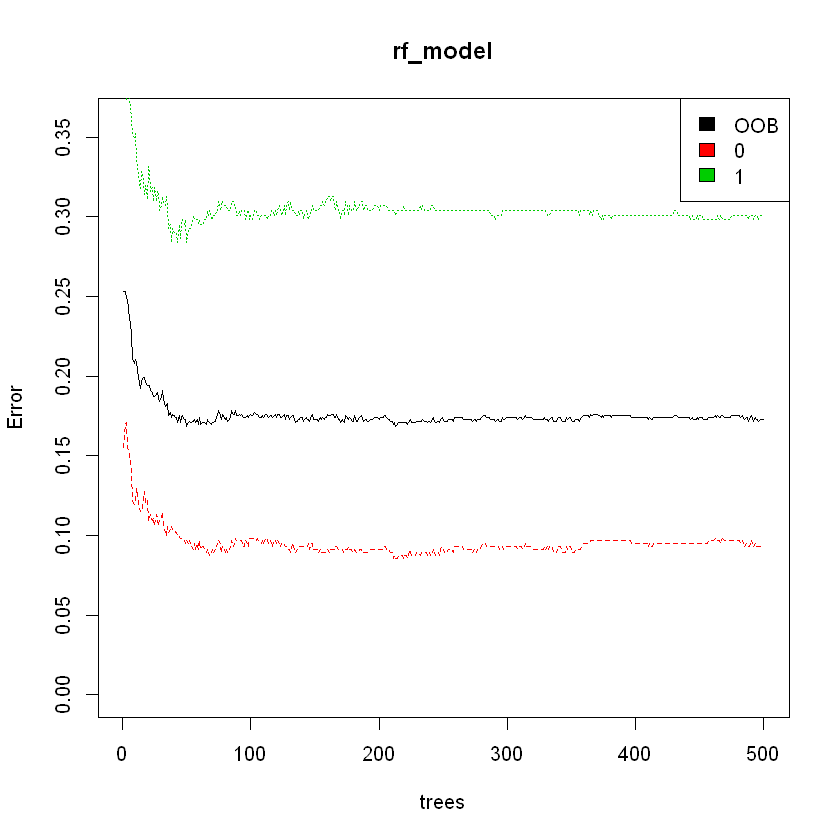

In [42]:
# Show model error
plot(rf_model, ylim=c(0,0.36))
legend('topright', colnames(rf_model$err.rate), col=1:3, fill=1:3)

The black line shows the overall error rate which falls below 20%. 
The red and green lines show the error rate for 'died' and 'survived' respectively. We can see that right now we're much more successful predicting death than we are survival.

# 7. Variable importance

Let's look at relative variable importance by plotting the mean decrease in Gini calculated across all trees.

In [43]:
# Get importance
importance    <- importance(rf_model)
varImportance <- data.frame(Variables = row.names(importance), 
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))


In [44]:
# Create a rank variable based on importance
rankImportance <- varImportance %>%
  mutate(Rank = paste0('#',dense_rank(desc(Importance))))

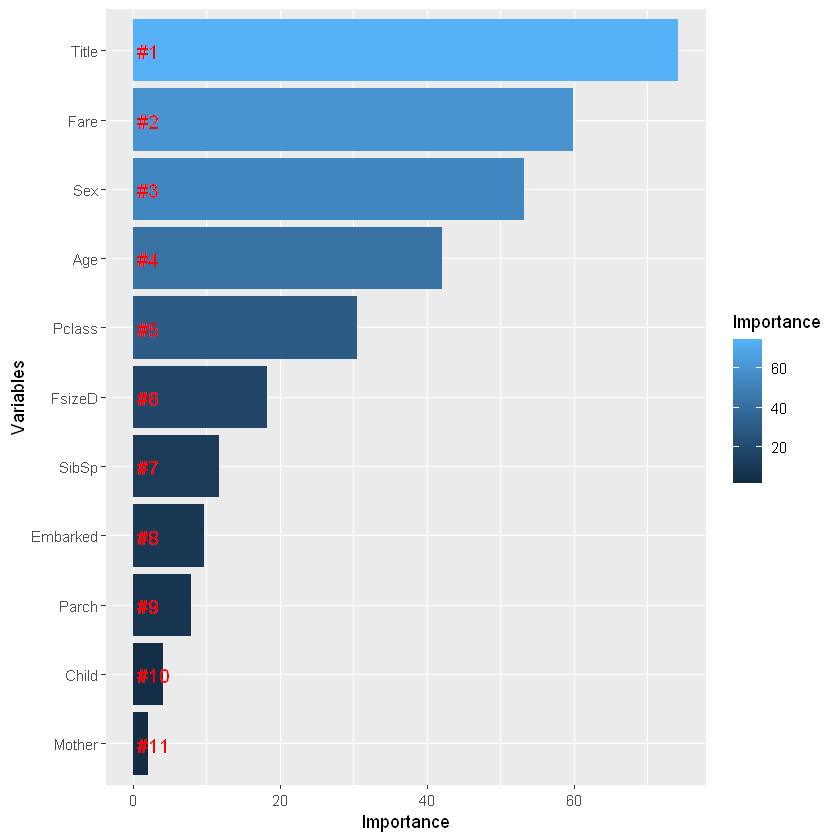

In [45]:
# Use ggplot2 to visualize the relative importance of variables
ggplot(rankImportance, aes(x = reorder(Variables, Importance), 
    y = Importance, fill = Importance)) +
  geom_bar(stat='identity') + 
  geom_text(aes(x = Variables, y = 0.5, label = Rank),
    hjust=0, vjust=0.55, size = 4, colour = 'red') +
  labs(x = 'Variables') +
  coord_flip() 

# 8. Evaluating our model: Confusion Matrix

In [46]:
# to test the model, make predictions using training data and compare the result with the truth
testing_prediction <- predict(rf_model, train)

In [47]:
cm <- confusionMatrix(data=testing_prediction, reference = factor(train$Survived))

In [48]:
draw_confusion_matrix <- function(cm) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'Class1', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'Class2', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'Class1', cex=1.2, srt=90)
  text(140, 335, 'Class2', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}  

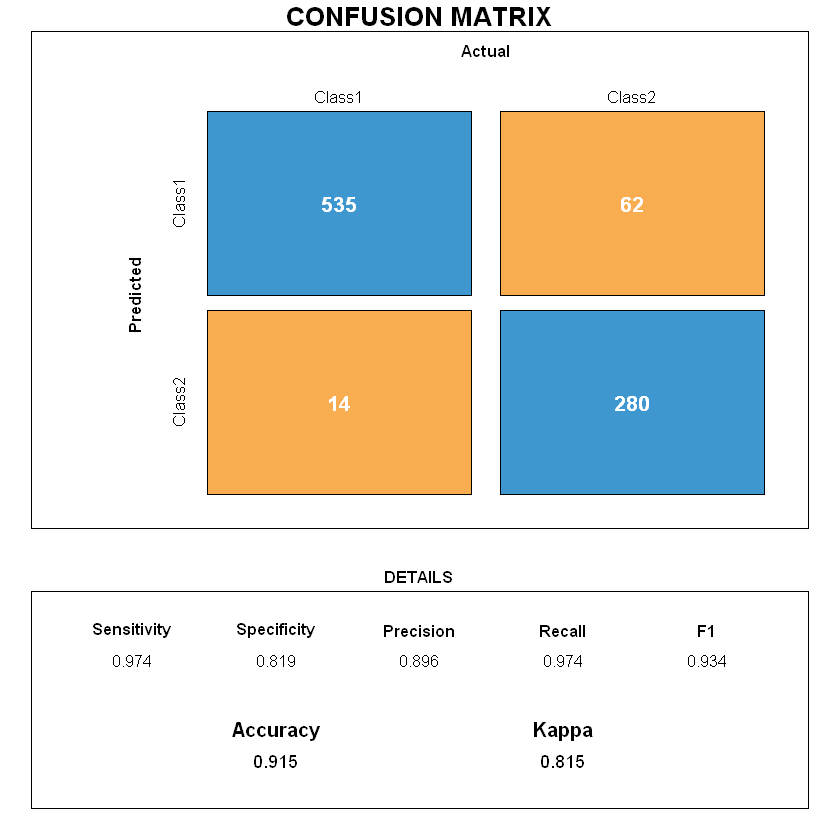

In [49]:
draw_confusion_matrix(cm)

# 9. Reference
https://www.kaggle.com/code/arunkumarramanan/data-science-in-r-and-titanic-survival-prediction
https://stackoverflow.com/questions/23891140/r-how-to-visualize-confusion-matrix-using-the-caret-package